## From previous assignment



In [4]:
# Code from the Lecture to compare our final result
import numba
import numpy as np
from numba import cuda, float32
import numba
from scipy.sparse import coo_matrix


#From previous assignement
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f


TPB = 16
N = 1000

NBG = (N + TPB -1)//TPB

h = 1/(N-1)

A, _ = discretise_poisson(N)

# Generate a random vector
rand = np.random.RandomState(0)

x = rand.randn(N * N)
y_exact = A @ x


# CPU benchmark
%timeit discretise_poisson(N)

1 loop, best of 3: 3.28 s per loop


In [5]:
@cuda.jit
def poisson_kernel_1(input_matrix, result):

  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y

  bx = cuda.blockIdx.x
  by = cuda.blockIdx.y

  px, py = cuda.grid(2)

  if (px >= result.shape[0] or py >= result.shape[1]):
    return

  if px == 0 or px == N - 1 or py == 0 or py == N -1 :
    result[px, py] = input_matrix[px,py]
  
  else:
    result[px, py] =  (4*input_matrix[px, py] -
                          input_matrix[px-1, py] - 
                          input_matrix[px+1, py] - 
                          input_matrix[px, py-1] - 
                          input_matrix[px, py+1] )/ (h**2)

In [6]:
# GPU benchmark

from numba import cuda, float32
import numba
import random

TPB = 16
N = 1000
h = 1/(N-1)

x = rand.randn(N * N)
input_matrix = x.reshape((N,N)) #Input ui,j matrix
device_input_matrix = cuda.to_device(input_matrix) #Input matrix moved to cuda device
device_result =  cuda.device_array((N, N), dtype=np.float64) #The array on cuda device to store result

nbg = (N + TPB -1)//TPB
poisson_kernel_1[(nbg, nbg), (TPB, TPB)](device_input_matrix, device_result)
result = device_result.copy_to_host()
result.reshape(N,N)

%timeit poisson_kernel_1[(nbg, nbg), (TPB, TPB)](device_input_matrix, device_result)
  

10000 loops, best of 3: 209 µs per loop


# Part 1

In [7]:
INPUT_SIZE = TPB + 2 # Getting neighbouring points

@cuda.jit
def poisson_kernel(input_matrix, result, omega):
  local_input_matrix = cuda.shared.array(( INPUT_SIZE, INPUT_SIZE), numba.float32)

  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y

  bx = cuda.blockIdx.x
  by = cuda.blockIdx.y

  px, py = cuda.grid(2)

  if (px >= result.shape[0] or py >= result.shape[1]):
    return
  
  local_input_matrix[tx + 1, ty + 1] = input_matrix[px, py]

# Boundary condition reading into shared memory
  if px != 0 and px != N - 1 and py != 0 and py != N -1 :
    if tx == 0:
      local_input_matrix[tx, ty + 1] = input_matrix[px - 1, py]
    if ty == 0:
      local_input_matrix[tx + 1, ty] = input_matrix[px, py - 1]
    if tx == TPB - 1:
      local_input_matrix[tx+2, ty + 1] = input_matrix[px + 1, py]
    if ty == TPB - 1:
      local_input_matrix[tx + 1, ty+2] = input_matrix[px, py + 1]

  index_x = tx + 1
  index_y = ty + 1
  cuda.syncthreads()

  if px == 0 or px == N - 1 or py == 0 or py == N -1 :
    result[px, py] = 0  # At each boundary point xk,  xk = 0.
  
  else:
    result[px, py] =  ((4*local_input_matrix[index_x, index_y] -
                          local_input_matrix[index_x-1, index_y] - 
                          local_input_matrix[index_x+1, index_y] - 
                          local_input_matrix[index_x, index_y-1] - 
                          local_input_matrix[index_x, index_y+1] )/ (h**2) +
                          local_input_matrix[index_x, index_y] * (omega)**2)
  

In [ ]:
omega=0
def solve_poisson_kernel_gpu(input_matrix):

  
  device_input_matrix = cuda.to_device(input_matrix) 

  nbg = (N + TPB -1)//TPB

  input_matrix.reshape(-1)

  input_matrix = x.reshape((N,N)) #Input ui,j matrix
  device_input_matrix = cuda.to_device(input_matrix) #input matrix moved to cuda device
  device_result =  cuda.device_array((N, N), dtype=np.float64) #The array on cuda device to store result

  poisson_kernel[(nbg, nbg), (TPB, TPB)](device_input_matrix, device_result, omega)
  result = device_result.copy_to_host()

  result = result.reshape(-1)

  return result
result = solve_poisson_kernel_gpu(input_matrix)

In [ ]:
%timeit poisson_kernel_1[(nbg, nbg), (TPB, TPB)](device_input_matrix, device_result) # Last assignment

10000 loops, best of 3: 223 µs per loop


In [ ]:
%timeit poisson_kernel[(nbg, nbg), (TPB, TPB)](device_input_matrix, device_result, omega) # This assignment

The slowest run took 4.67 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 264 µs per loop


#### GPU runtime here is similar to the one in previous assignment, only around 40 microseconds larger. Modified problem has not shifted the computing time significantly. 



### Validation 

In [ ]:
y_exact = (A @ x).reshape(N,N)
def boundary_zero(y):
  for i in range(N):
    for j in range(N):
      if i == 0 or j == 0 or i == N - 1 or j == N - 1:
        y[i, j] = 0
  return y
y_exact = boundary_zero(y_exact)
y_exact = y_exact.reshape(-1)
y_exact

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
result = result.reshape(-1)
rel_error = np.linalg.norm(result - y_exact, np.inf) / np.linalg.norm(y_exact, np.inf)
print(f"Error: {round(rel_error, 2)}.")

Error: 0.0.


#Part 2

In [ ]:
from scipy.sparse.linalg import LinearOperator
A = LinearOperator((N*N,N*N), matvec=solve_poisson_kernel_gpu)

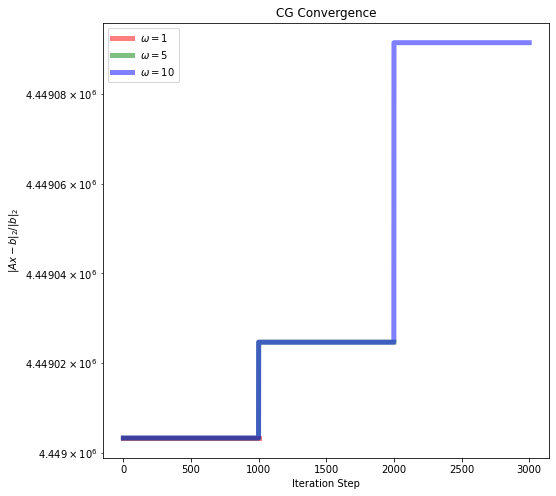

In [ ]:
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt

omegaArray = [1, 5, 10]
lines = ['r-', 'g-', 'b-']
b = np.ones(N*N)
residuals = []

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

for omega, line in zip(omegaArray, lines):
  A = LinearOperator((N*N,N*N), matvec=solve_poisson_kernel_gpu)

  callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))

  sol, _ = cg(A, b, callback=callback, maxiter=1000)

 
  
  ax.semilogy(1 + np.arange(len(residuals)), residuals, line, label=f'$\omega={omega}$', alpha=0.5, linewidth = 5)
ax.set_title('CG Convergence')
ax.set_xlabel('Iteration Step')
_ = ax.set_ylabel('$\|Ax-b\|_2 / \|b\|_2$')
ax.legend()


#### For CG method, increment directions are chosen to be conjugate orthogonal, explaining the plot.

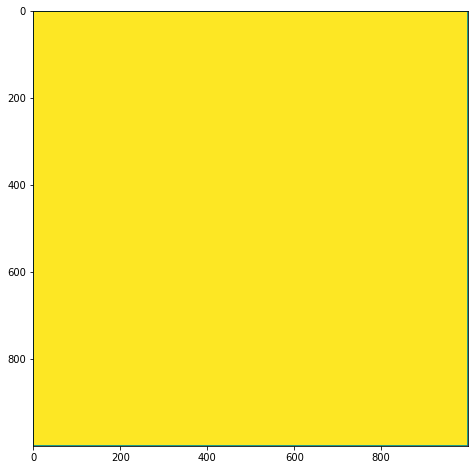

In [ ]:
omega =  1
from scipy.sparse.linalg import LinearOperator
A = LinearOperator((N*N,N*N), matvec=solve_poisson_kernel_gpu)
b = np.ones(N*N)
b = b.reshape(N,N)
b = boundary_zero(b)
b = b.reshape(-1)
residuals = []

callback = lambda x: residuals.append(np.linalg.norm(b - A @ x) / np.linalg.norm(b))

sol, _ = cg(A, b,  callback=callback, maxiter=20)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.imshow(sol.reshape(N,N))